# Gradient Boosted Decision Trees

In [1]:
# pip install xgboost

In [2]:
#Importing required libraries
import numpy as np
import pandas as pd
np.random.seed(3116)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#Scikit learn modules
import xgboost
from sklearn.datasets import make_moons
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
#GENERATING THE DATASET
#List of different noise levels
noise_levels = [1, 0.8, 0.3, 0.1, 0.08, 0.03, 0.01, 0.005, 0.001, 0] 
df = []
for n in noise_levels:
    covariates, target_values = make_moons(n_samples=100, noise = n, random_state=3116)
    covariates = pd.DataFrame(covariates) #Converting to pandas dataframe objects
    target_values = pd.DataFrame(target_values, columns = ["Target_Value"])
    current_data = pd.concat([covariates, target_values], axis =1)
    df.append(current_data)

toy_dataset = pd.concat(df)
toy_dataset.head()

,0,1,Target_Value
0,0.859761,1.117983,1
1,2.220382,-0.887305,1
2,-0.806098,-0.546678,1
3,-0.190111,1.842946,0
4,-0.035493,-0.274843,1


## Visualizing 10 different pairs of moon -- randomly selected from toy data


1. Generate a binary classification toy dataset from the scikit-learn utility ”make-moons”. Please generate 100 samples, for 10 different levels of noise which should give you a toy-dataset of 1000 samples. Here sample refers to a single point in 2-D, and it’s corresponding label (0 vs. 1) denoting membership in either of the two moons. Visualize the 10 different pairs of so-called moons.

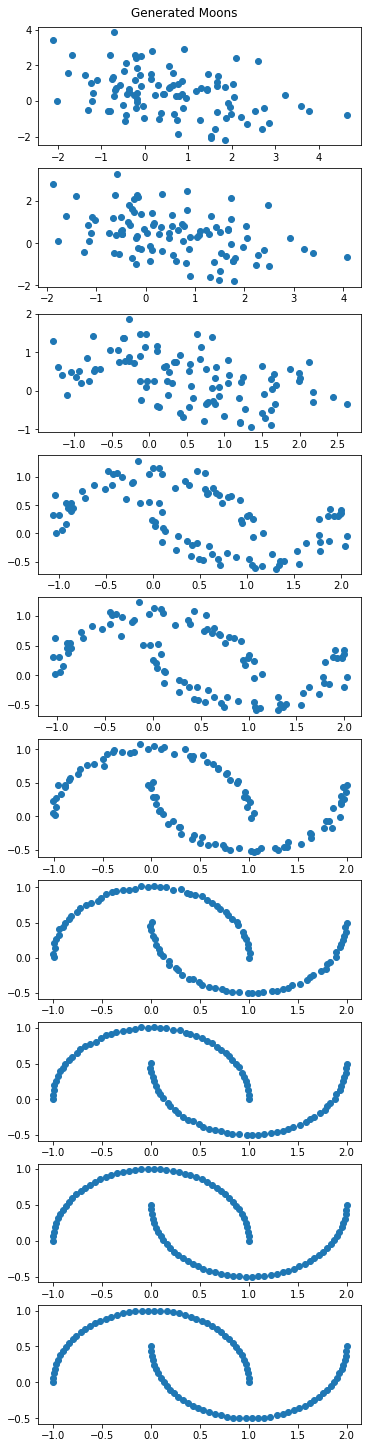

In [4]:

# for 10 different moons
x_values = toy_dataset.iloc[:, 0].to_numpy()
y_values = toy_dataset.iloc[:, 1].to_numpy()
n = 100
fig, ax = plt.subplots(10, figsize=(5, 20), constrained_layout=True)
fig.suptitle('Generated Moons')
for i in range(10):
    ax[i].scatter(x_values[i*n : (i+1)*n], y_values[i*n : (i+1)*n])

###  2. Generate train/validation/test splits with the ratios like before.

In [5]:
# GENERATING DATASET SPLITS
# The following function take a dataframe object as input and returns 3 dfs having train/test/validation instances
def train_test_val_split(df, test_ratio, val_ratio):
    n_test = int(test_ratio*df.shape[0]) #Training/validation set size within current class label
    n_val = int(val_ratio*df.shape[0])
    n_train = 1 - n_test - n_val
    permute = np.random.permutation(df.index)
    train_data = df.iloc[permute[:n_train]]
    validation_data = df.iloc[permute[n_train : n_train+n_val]]
    test_data = df.iloc[permute[n_train+n_val:]]
    train_y = train_data["Target_Value"].to_numpy()
    train_x = train_data.drop(["Target_Value"], axis=1).to_numpy()
    val_y = validation_data["Target_Value"].to_numpy()
    val_x = validation_data.drop(["Target_Value"], axis=1).to_numpy()
    test_y = test_data["Target_Value"].to_numpy()
    test_x = test_data.drop(["Target_Value"], axis=1).to_numpy()
    dataset = [(train_x, train_y), (test_x, test_y), (val_x, val_y)] #List of all required dataset splits
    return dataset

In [6]:
#Splitting the toy data
test_ratio, val_ratio = 0.15, 0.15

(x_train, y_train), (x_test, y_test), (x_val, y_val) = train_test_val_split(toy_dataset, test_ratio, val_ratio)
print('\nShape of train set is: ',x_train.shape)
print('\nShape of validation set is: ',x_val.shape)
print('\nShapes of test set are: ',x_test.shape)


Shape of train set is:  (701, 2)

Shape of validation set is:  (150, 2)

Shapes of test set are:  (149, 2)


### 3. Please keep max depth of trees to 2 i.e root node then leaf nodes (also called stumps), and tune number of trees in the ensemble on the validation set.

In [9]:
#Building a XGBoost Classifier and fitting the training data to the model

gradient_boosting = xgboost.XGBClassifier(learning_rate = 0.01,max_depth = 2,n_estimators = 1000,eval_metric = 'error',verbosity = 1)
#Passing evaluation set also to avoid model overfitting by early stopping
validation_set = [(x_val, y_val)]
gradient_boosting.fit(x_train, y_train, early_stopping_rounds=8, eval_set = validation_set, verbose=True)

[0]	validation_0-error:0.34667
[1]	validation_0-error:0.26000
[2]	validation_0-error:0.26000
[3]	validation_0-error:0.26000
[4]	validation_0-error:0.26000
[5]	validation_0-error:0.20667
[6]	validation_0-error:0.26000
[7]	validation_0-error:0.26000
[8]	validation_0-error:0.20000
[9]	validation_0-error:0.18667
[10]	validation_0-error:0.20667
[11]	validation_0-error:0.20667
[12]	validation_0-error:0.20667
[13]	validation_0-error:0.20667
[14]	validation_0-error:0.20667
[15]	validation_0-error:0.20667
[16]	validation_0-error:0.20667
[17]	validation_0-error:0.20667


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### 4. Report test-accuracy.

In [10]:
#Now that the model has been trained, we will see the validation and test accuracy

val_y_predicted = gradient_boosting.predict(x_val)
val_acc = accuracy_score(y_val, val_y_predicted)
test_y_predicted = gradient_boosting.predict(x_test)
test_acc = accuracy_score(y_test, test_y_predicted)
print(f"Validation Accuracy: {val_acc}")
print(f"Test Accuracy: {test_acc}")

Validation Accuracy: 0.8133333333333334
Test Accuracy: 0.7718120805369127


In [ ]:
#### Reference: https://xgboost.readthedocs.io/en/stable/parameter.html